In [36]:
# Import necessary libraries
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
dataset = pd.read_csv('Customers.csv') 

# Show dataset information and first 5 rows
print("Dataset Information:")
print(dataset.info())
print("\nFirst 5 Rows of Dataset:")
print(tabulate(dataset.head(), headers='keys', tablefmt='pretty'))


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB
None

First 5 Rows of Dataset:
+---+------------+--------+-----+-------------------+------------------------+---------------+-----------------+-------------+
|   | CustomerID | Gender | Age | Annual Income ($) | Spending Score (1-100) |  Profession   | Work Experience | Family Size |
+---+-----------

In [37]:
#data cleaning and preprocessing,normalization

Missing values handled.
customerid id is removed
Encoding column: Gender

Mapping for column 'Gender':
0: Female, 1: Male
Encoding column: Profession

Mapping for column 'Profession':
0: Artist, 1: Doctor, 2: Engineer, 3: Entertainment, 4: Executive, 5: Healthcare, 6: Homemaker, 7: Lawyer, 8: Marketing
Categorical data encoded.

First 5 Rows of Dataset after Encoding:
+----+----------+-------+---------------------+--------------------------+--------------+-------------------+---------------+
|    |   Gender |   Age |   Annual Income ($) |   Spending Score (1-100) |   Profession |   Work Experience |   Family Size |
+====+==========+=======+=====================+==========================+==============+===================+===============+
|  0 |        1 |    19 |               15000 |                       39 |            5 |                 1 |             4 |
+----+----------+-------+---------------------+--------------------------+--------------+-------------------+---------------+

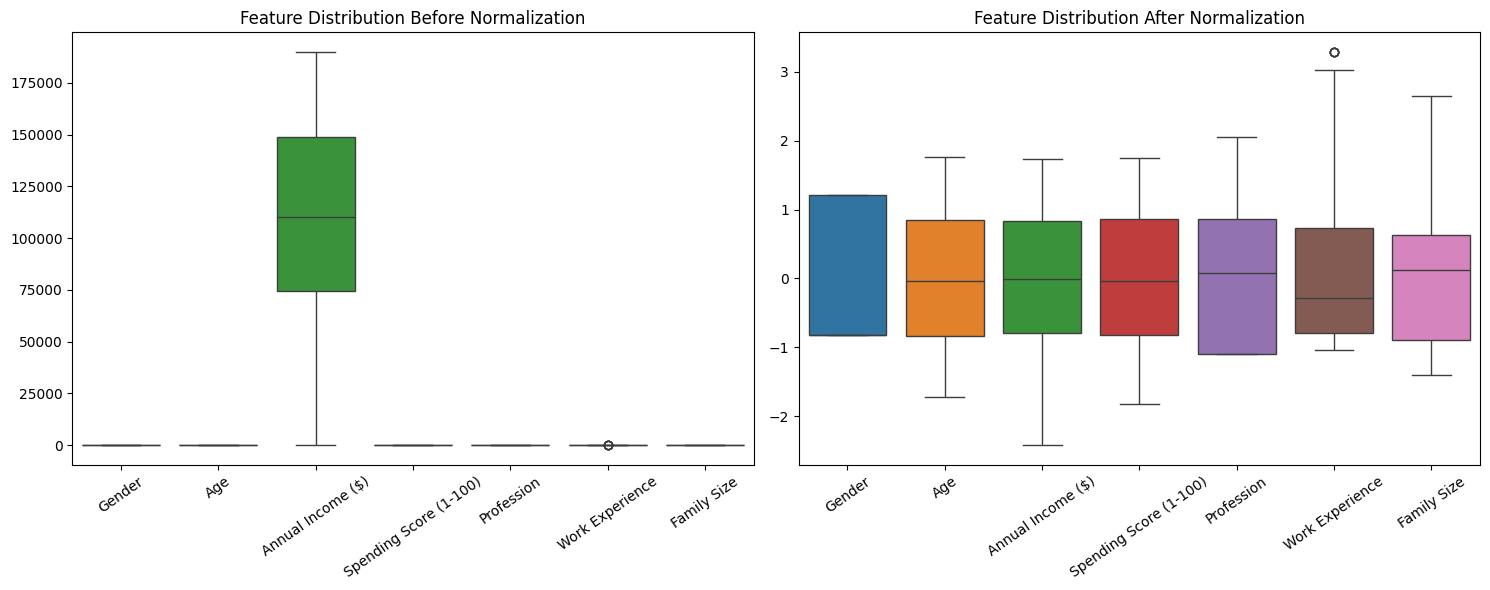

Cleaned dataset saved as 'cleaned_Customers_dataset.csv'.


In [38]:
# Fill missing values with the most frequent value in each column
dataset = dataset.apply(lambda x: x.fillna(x.mode()[0]) if x.isna().sum() > 0 else x)
print("Missing values handled.")

# Drop 'CustomerID' 
if 'CustomerID' in dataset.columns:
    dataset = dataset.drop('CustomerID', axis=1)
print("customerid id is removed")

label_encoders = {}

# Convert categorical columns to numerical values
categorical_columns = dataset.select_dtypes(include='object').columns
if categorical_columns.empty:
    print("No categorical columns found for encoding.")
else:
    for column in categorical_columns:
        le = LabelEncoder()
        dataset[column] = le.fit_transform(dataset[column])
        label_encoders[column] = le  # Store encoder to access class mappings later
        print("Encoding column:", column)

        # Generate and print the mapping in the desired format
        mapping = {idx: category for idx, category in enumerate(le.classes_)}
        mapping_output = ', '.join([f"{idx}: {category}" for idx, category in mapping.items()])
        print(f"\nMapping for column '{column}':")
        print(mapping_output)

print("Categorical data encoded.")
print("\nFirst 5 Rows of Dataset after Encoding:")
print(tabulate(dataset.head(), headers='keys', tablefmt='grid'))
# Normalize the data
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Plotting before and after normalization side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot data distribution before normalization
sns.boxplot(data=dataset, ax=axes[0])
axes[0].set_title("Feature Distribution Before Normalization")
for label in axes[0].get_xticklabels():
    label.set_rotation(35)


# Plot data distribution after normalization
sns.boxplot(data=normalized_data, ax=axes[1])
axes[1].set_title("Feature Distribution After Normalization")
for label in axes[1].get_xticklabels():
    label.set_rotation(35)


plt.tight_layout()
plt.show()

# Save the cleaned, normalized dataset
cleaned_data_afterNormalization = normalized_data.copy()  # Save a copy for later use


cleaned_data_afterNormalization.to_csv('cleaned_Customers_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_Customers_dataset.csv'.")



In [39]:
#visualizing the dataset

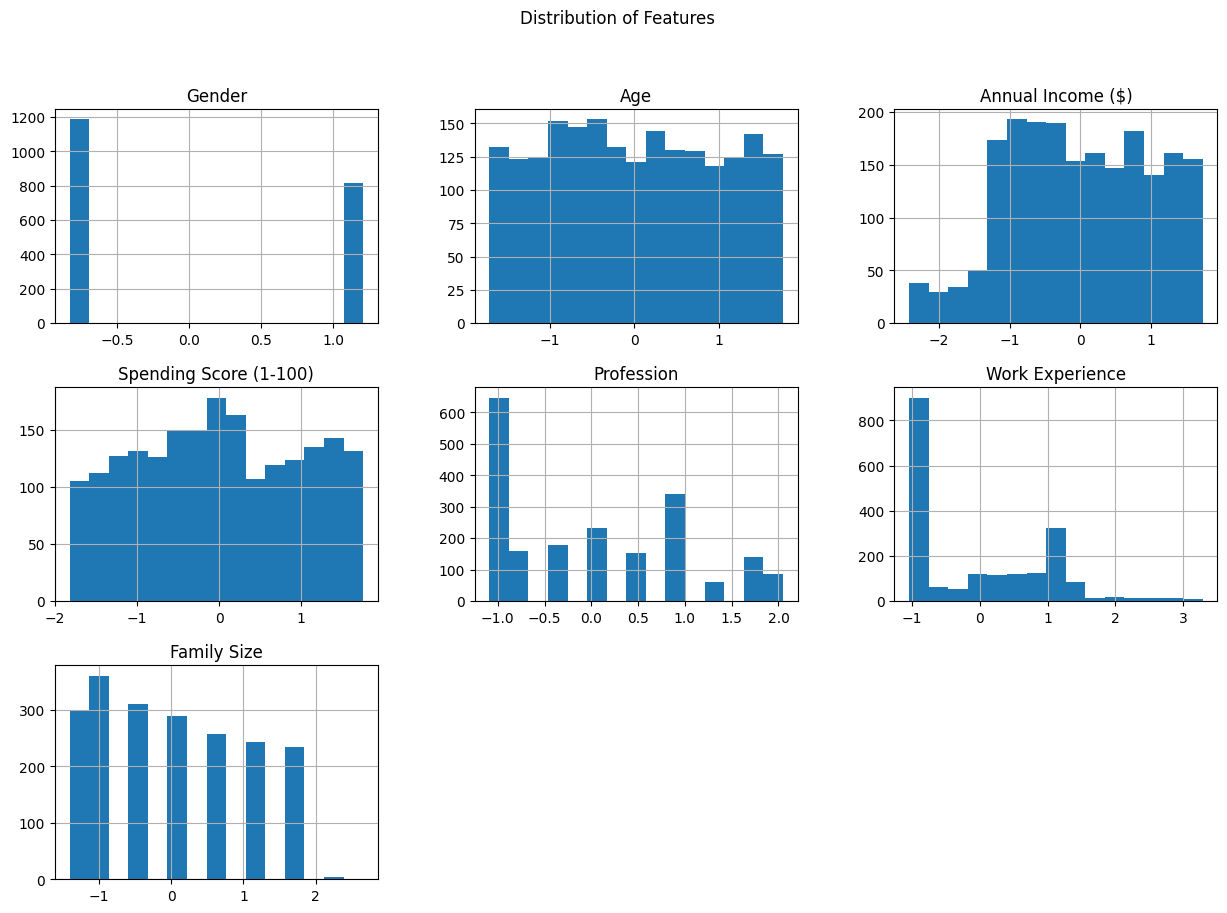

In [40]:
# Plot histograms for each column
cleaned_data_afterNormalization.hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribution of Features')
plt.show()


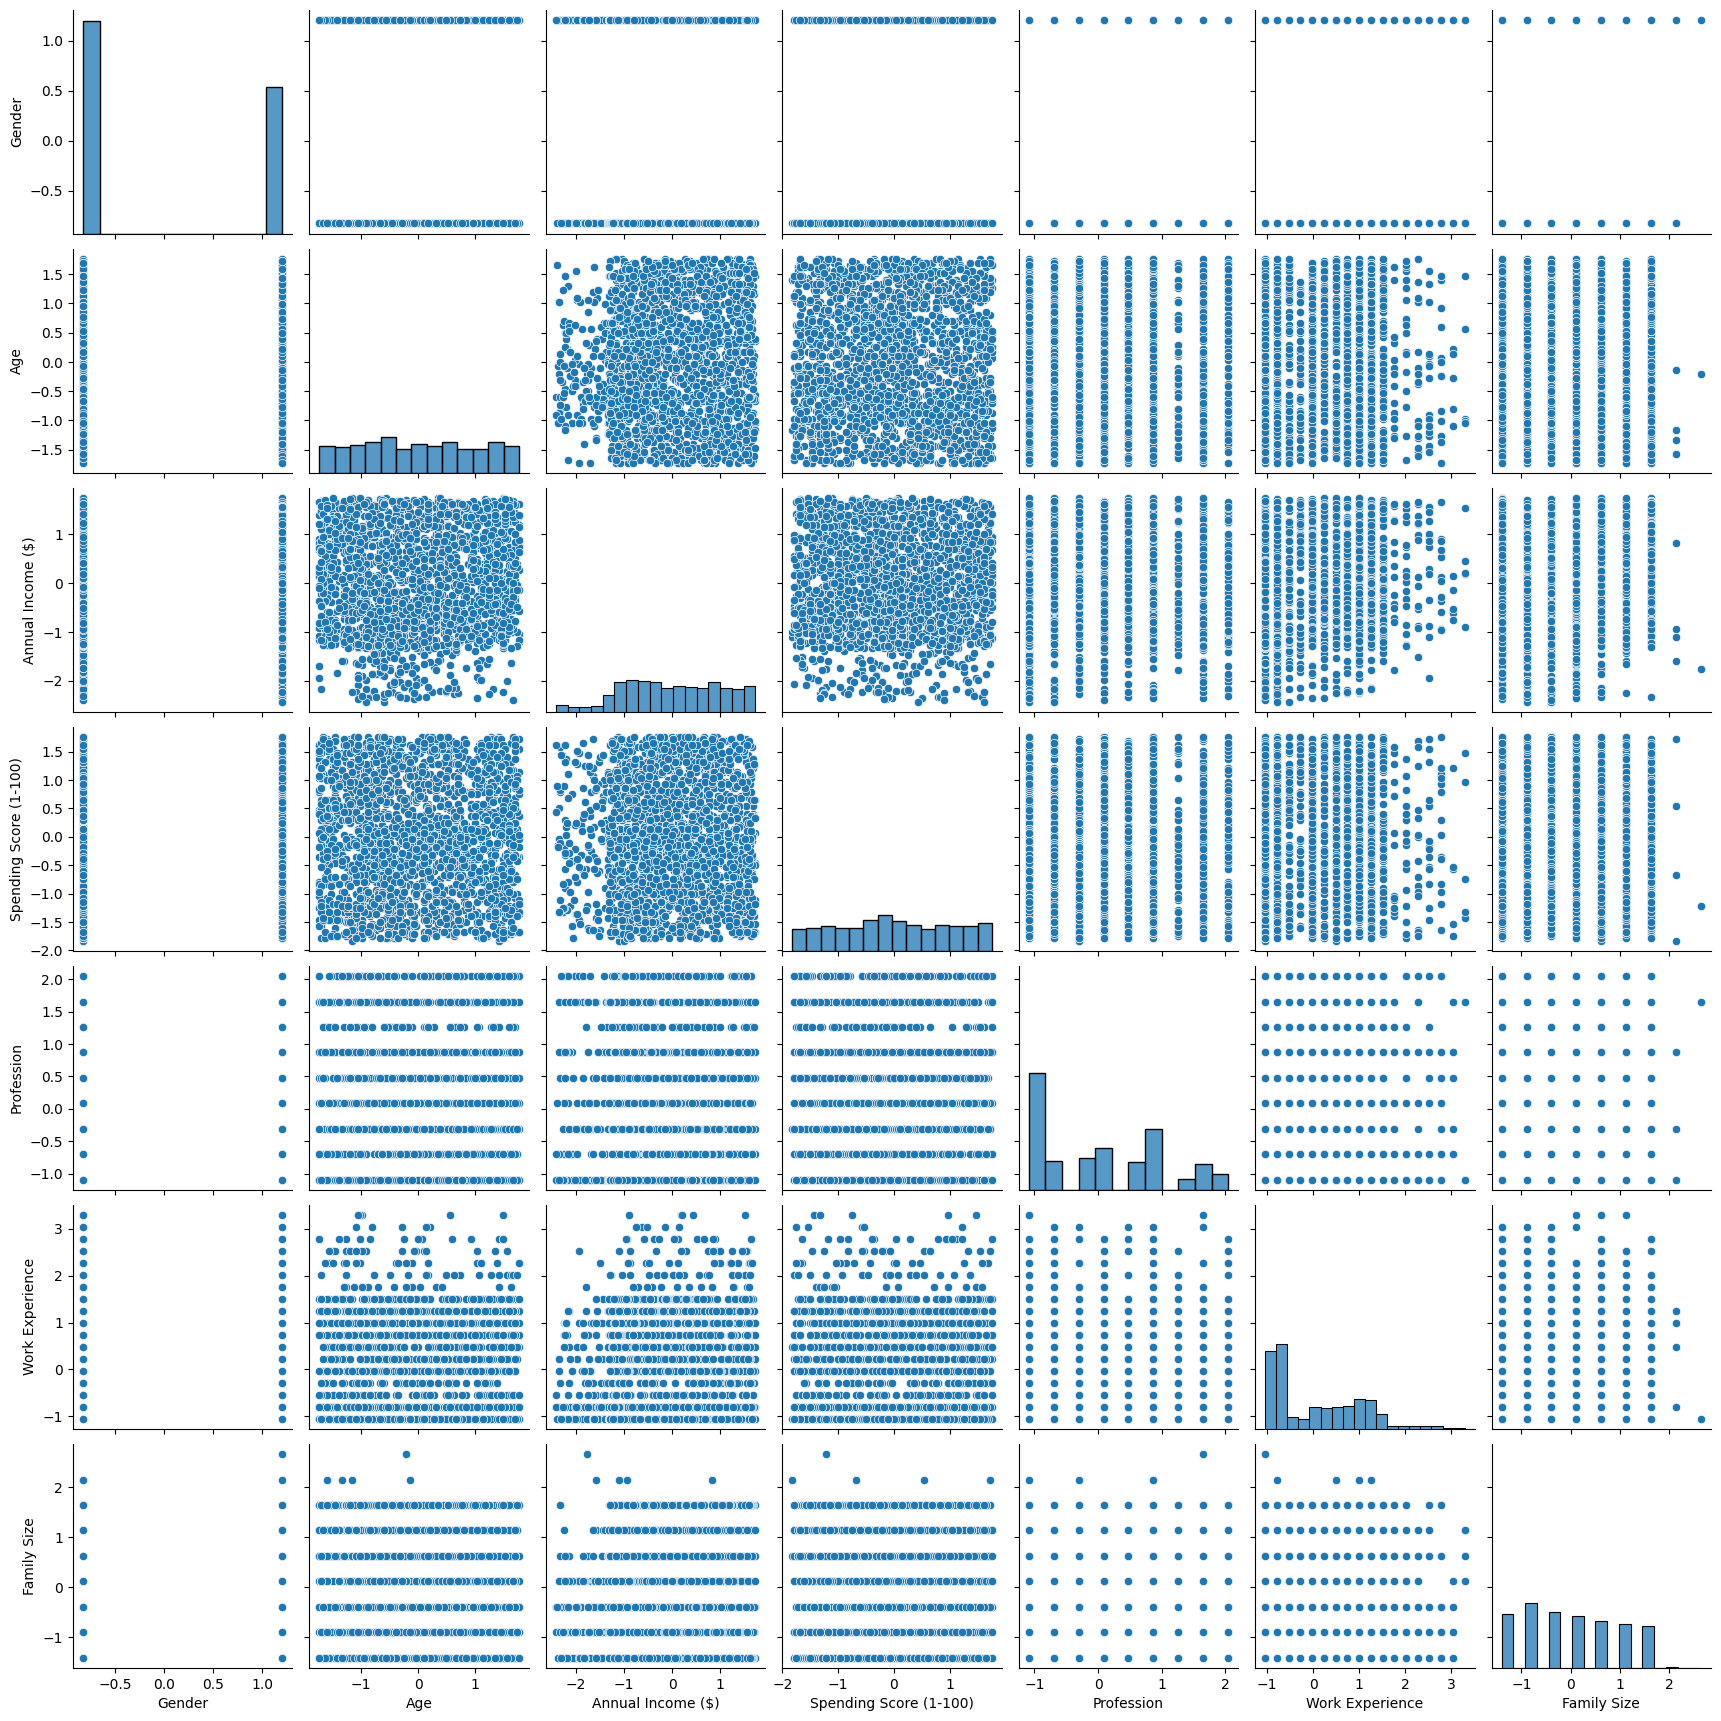

In [41]:
# Pairplot to visualize relationships
sns.pairplot(cleaned_data_afterNormalization)
plt.show()


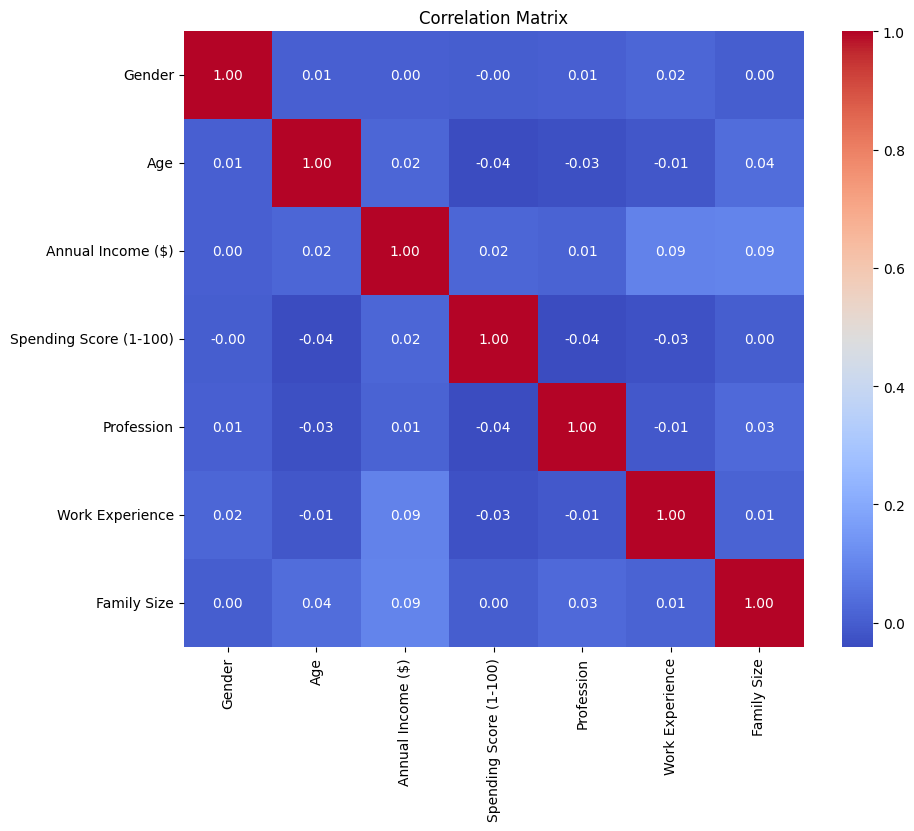

In [42]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_data_afterNormalization.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [43]:
# checking outliers

In [44]:
z_scores = np.abs(stats.zscore(cleaned_data_afterNormalization))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
print(outliers)

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 2000, dtype: bool


In [45]:
## Removes outliers which are important for kmeans etc..
## utliers are data points that significantly differ from the rest of the data in a dataset.

def remove_outliers_iqr(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).any(axis=1)
    outlier_data = data[outliers]
    print(f"Number of Outliers: {outliers.sum()}")
    # Filter out outliers
    return data[~outliers]

# Apply the IQR outlier removal to normalized_data
cleaned_data_ForKmeans_and_Gmm = remove_outliers_iqr(cleaned_data_afterNormalization)

Number of Outliers: 5


In [46]:
z_scores = np.abs(stats.zscore(cleaned_data_ForKmeans_and_Gmm))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
print(outliers)

0       False
1       False
2       False
3       False
4       False
        ...  
1995    False
1996    False
1997    False
1998    False
1999    False
Length: 1995, dtype: bool


In [47]:
#clustering algorithms
# 1.k-means

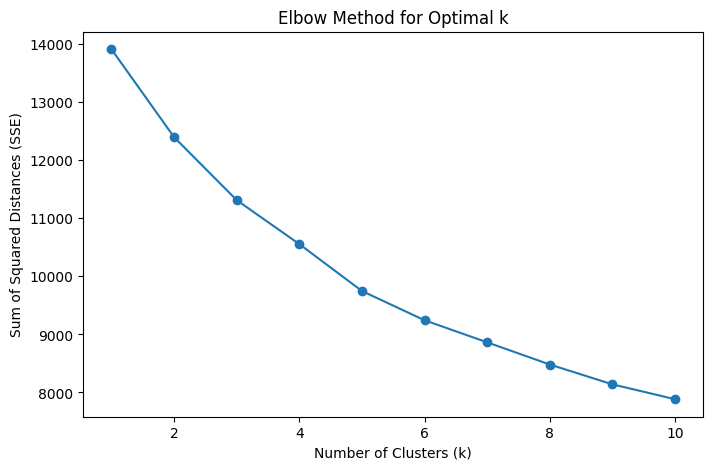

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method to determine optimal K ,sharp change in the SSE curve to identify the elbow
sse = []
k_values = range(1, 11)  # Test k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(cleaned_data_ForKmeans_and_Gmm)
    sse.append(kmeans.inertia_)  # Inertia: sum of squared distances to nearest cluster center

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [49]:
print(sse)

[13913.455801510949, 12398.210496202777, 11313.272482996668, 10555.944747468991, 9747.677603331358, 9243.834259700983, 8863.597586547645, 8481.280365555733, 8139.754622202479, 7883.705547876754]


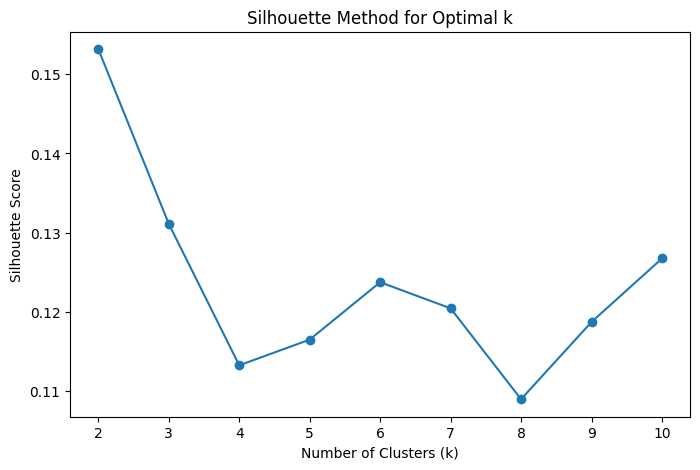

In [50]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(cleaned_data_afterNormalization)
    silhouette_scores.append(silhouette_score(cleaned_data_afterNormalization, labels))

# Plot Silhouette Score vs. number of clusters (k)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

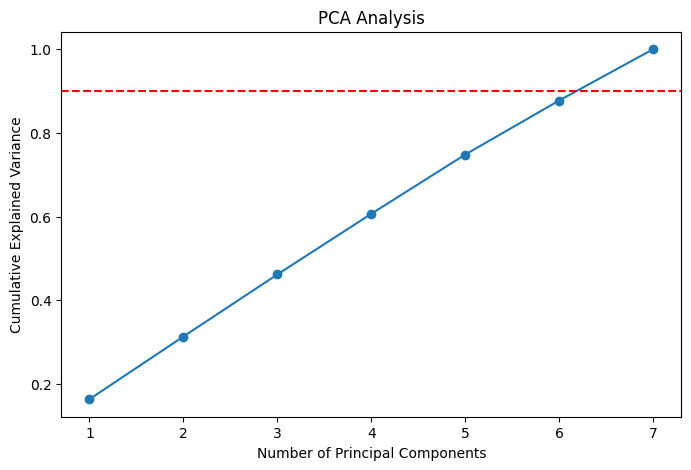

In [51]:
from sklearn.decomposition import PCA
import numpy as np
#curve flattens out
pca = PCA().fit(cleaned_data_ForKmeans_and_Gmm)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis')
plt.axhline(y=0.90, color='r', linestyle='--')  # 90% variance line for reference
plt.show()


K = 2, PCA = 5:
  Silhouette Score: 0.208
  Calinski-Harabasz Score: 467.475
  Davies-Bouldin Score: 1.945

K = 2, PCA = 6:
  Silhouette Score: 0.176
  Calinski-Harabasz Score: 387.374
  Davies-Bouldin Score: 2.165

K = 2, PCA = 7:
  Silhouette Score: 0.108
  Calinski-Harabasz Score: 243.574
  Davies-Bouldin Score: 2.808

K = 3, PCA = 5:
  Silhouette Score: 0.173
  Calinski-Harabasz Score: 382.237
  Davies-Bouldin Score: 1.879

K = 3, PCA = 6:
  Silhouette Score: 0.120
  Calinski-Harabasz Score: 266.427
  Davies-Bouldin Score: 2.224

K = 3, PCA = 7:
  Silhouette Score: 0.105
  Calinski-Harabasz Score: 228.922
  Davies-Bouldin Score: 2.380

K = 4, PCA = 5:
  Silhouette Score: 0.156
  Calinski-Harabasz Score: 343.891
  Davies-Bouldin Score: 1.623

K = 4, PCA = 6:
  Silhouette Score: 0.147
  Calinski-Harabasz Score: 275.298
  Davies-Bouldin Score: 2.236

K = 4, PCA = 7:
  Silhouette Score: 0.104
  Calinski-Harabasz Score: 211.094
  Davies-Bouldin Score: 2.182

K = 5, PCA = 5:
  Silhouette

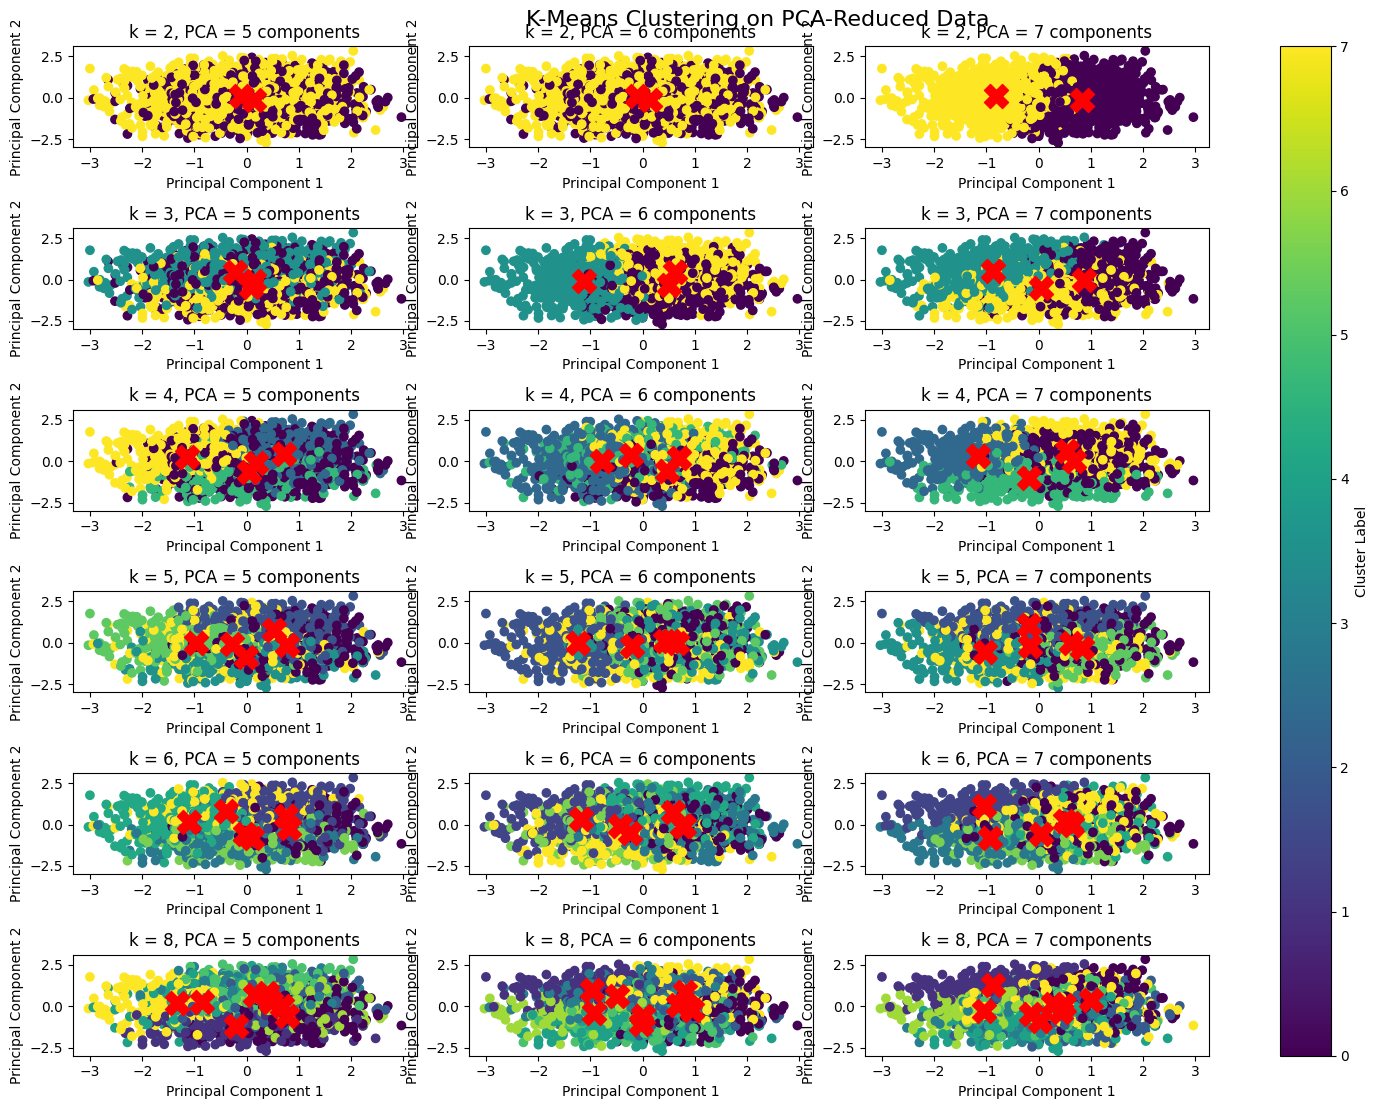

In [52]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Define the range of k and n_components to iterate over
k_values = [2, 3, 4, 5, 6, 8]
pca_components = [5, 6, 7]

# Plotting for different combinations of k and PCA components
fig, axes = plt.subplots(len(k_values), len(pca_components), figsize=(15, 12))
fig.suptitle('K-Means Clustering on PCA-Reduced Data', fontsize=16, y=0.92)

for i, k in enumerate(k_values):
    for j, n_components in enumerate(pca_components):
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_data)  # Capture the labels here
        
        # Plot the clustering results
        ax = axes[i, j]
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
        ax.set_title(f'k = {k}, PCA = {n_components} components')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')

        # Compute performance metrics
        silhouette = silhouette_score(reduced_data, labels)
        calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
        davies_bouldin = davies_bouldin_score(reduced_data, labels)
        
        print(f"K = {k}, PCA = {n_components}:")
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}\n")

# Adjust layout and add color bar
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.colorbar(scatter, ax=axes.ravel().tolist(), label='Cluster Label')
plt.show()


K = 2, PCA = 3:
  Silhouette Score: 0.223
  Calinski-Harabasz Score: 593.854
  Davies-Bouldin Score: 1.698

K = 3, PCA = 3:
  Silhouette Score: 0.234
  Calinski-Harabasz Score: 642.544
  Davies-Bouldin Score: 1.341

K = 4, PCA = 3:
  Silhouette Score: 0.245
  Calinski-Harabasz Score: 692.961
  Davies-Bouldin Score: 1.137

K = 5, PCA = 3:
  Silhouette Score: 0.238
  Calinski-Harabasz Score: 665.061
  Davies-Bouldin Score: 1.163

K = 6, PCA = 3:
  Silhouette Score: 0.241
  Calinski-Harabasz Score: 660.808
  Davies-Bouldin Score: 1.101

K = 8, PCA = 3:
  Silhouette Score: 0.225
  Calinski-Harabasz Score: 607.048
  Davies-Bouldin Score: 1.167



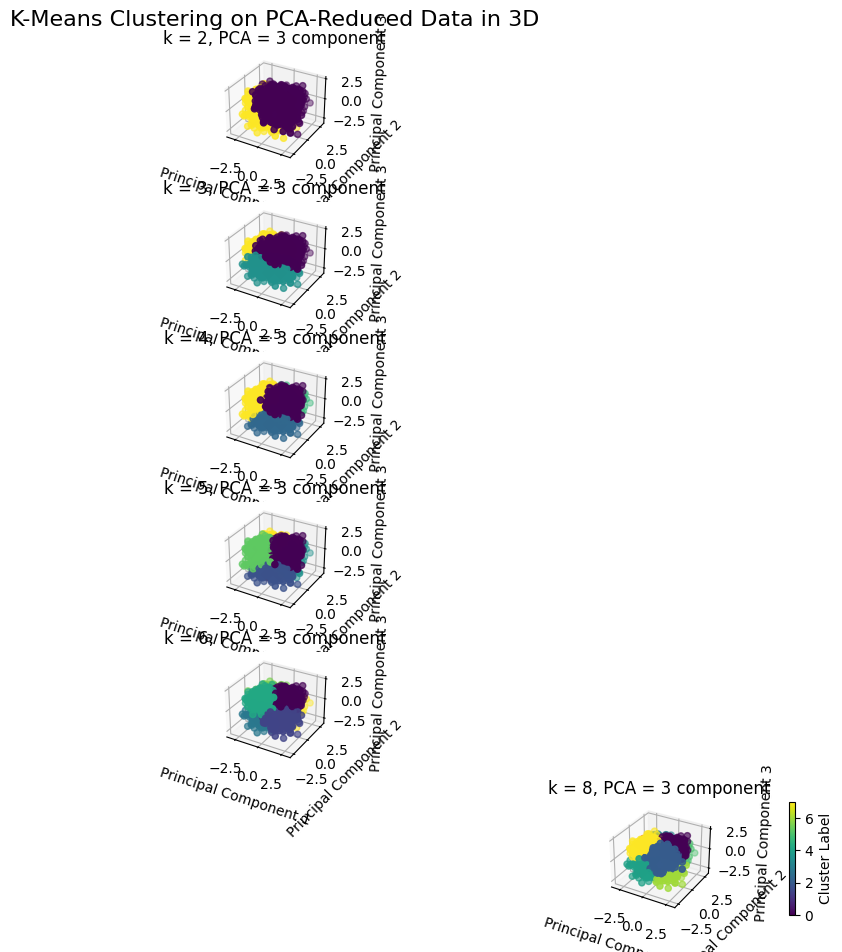

In [53]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the range of k and n_components to iterate over
k_values = [2, 3, 4, 5, 6, 8]
pca_components = [3]  # Only 3 components for 3D plot

# Plotting for different combinations of k and PCA components
fig = plt.figure(figsize=(15, 10))
fig.suptitle('K-Means Clustering on PCA-Reduced Data in 3D', fontsize=16, y=0.92)

for i, k in enumerate(k_values):
    for j, n_components in enumerate(pca_components):
        # Apply PCA
        pca = PCA(n_components=n_components)
        reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)
        
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_data)
        
        # Create a 3D subplot
        ax = fig.add_subplot(len(k_values), len(pca_components), i * len(pca_components) + j + 1, projection='3d')
        
        # Plot the clustering results
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', marker='o')
        ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='red', marker='X')
        
        ax.set_title(f'k = {k}, PCA = {n_components} component')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')

        # Compute performance metrics
        silhouette = silhouette_score(reduced_data, labels)
        calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
        davies_bouldin = davies_bouldin_score(reduced_data, labels)
        
        print(f"K = {k}, PCA = {n_components}:")
        print(f"  Silhouette Score: {silhouette:.3f}")
        print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}\n")

# Adjust layout and add color bar
plt.tight_layout(rect=[0, 0, 1, 0.95])
cbar = plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()


/Users/gowthamkishorevijay/Desktop/Playground/projects/my-venv/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning:

Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/gowthamkishorevijay/Desktop/Playground/projects/my-venv/lib/python3.12/site-packages/trame/widgets/__init__.py)

Falling back to a static output.



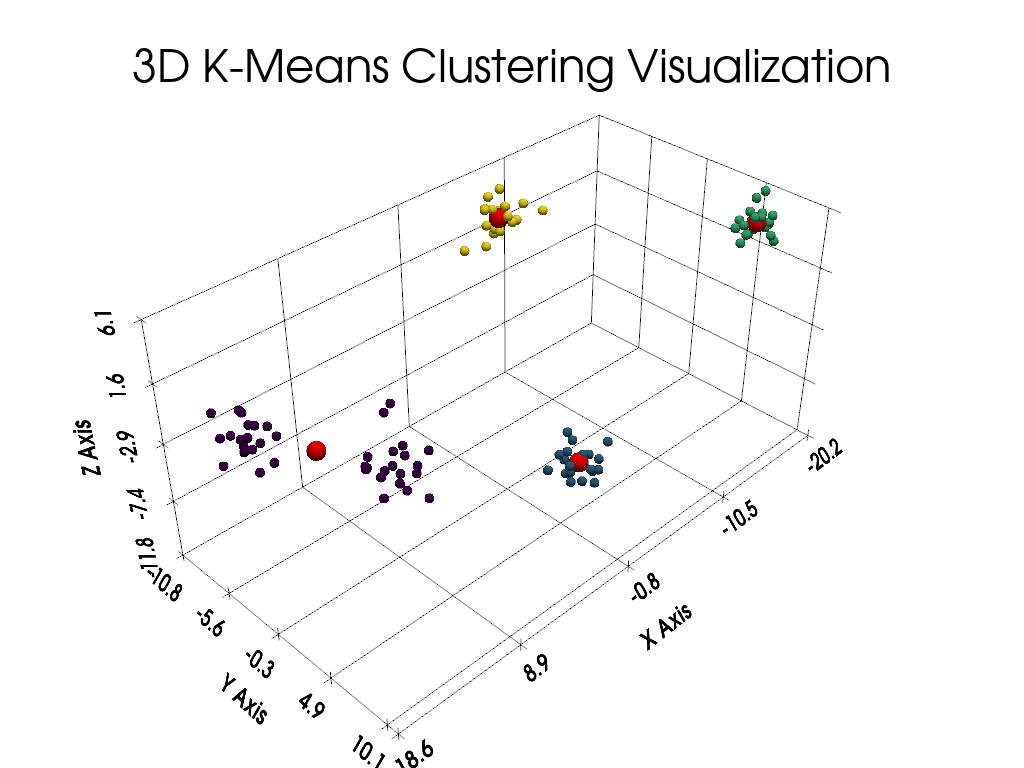

In [54]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate synthetic data for demonstration
n_samples = 100
n_features = 10
X, _ = make_blobs(n_samples=n_samples, centers=5, n_features=n_features, random_state=42)

# Apply PCA to reduce to 3 components for 3D visualization
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X)

# Apply KMeans clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)
centroids = kmeans.cluster_centers_

# Create a PyVista plotter
plotter = pv.Plotter()

# Define a fixed color palette for clusters
colors = plt.cm.viridis(np.linspace(0, 1, k))

# Plot the points with different colors for each cluster
for cluster in range(k):
    cluster_points = reduced_data[labels == cluster]
    plotter.add_points(cluster_points, color=colors[cluster], point_size=10, render_points_as_spheres=True)

# Add centroids in red
plotter.add_points(centroids, color='red', point_size=20, render_points_as_spheres=True)

# Set plot title and axis labels
plotter.add_title("3D K-Means Clustering Visualization")
plotter.show_grid()

# Show the plot
plotter.show()


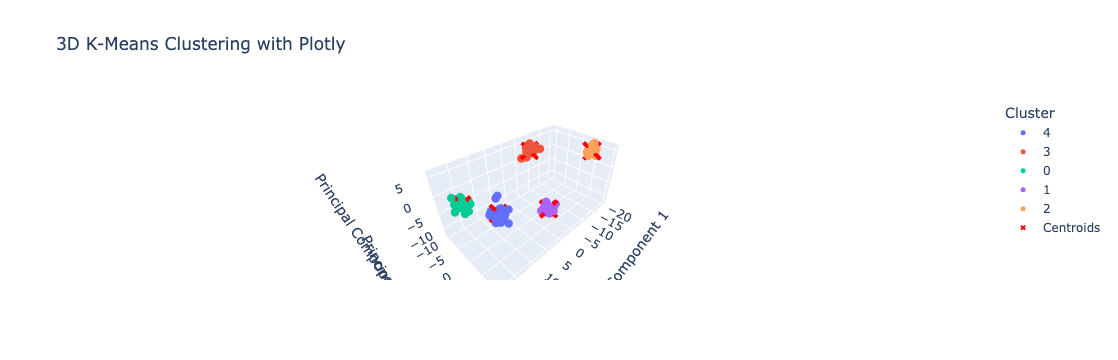

In [55]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate synthetic data for demonstration
n_samples = 100
n_features = 10
X, _ = make_blobs(n_samples=n_samples, centers=5, n_features=n_features, random_state=42)

# Apply PCA to reduce to 3 components for 3D visualization
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X)

# Apply KMeans clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)
centroids = kmeans.cluster_centers_

# Plot with Plotly
fig = px.scatter_3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    color=labels.astype(str),
    title='3D K-Means Clustering with Plotly',
    labels={'color': 'Cluster'}
)

# Add cluster centroids
fig.add_scatter3d(
    x=centroids[:, 0],
    y=centroids[:, 1],
    z=centroids[:, 2],
    mode='markers',
    marker=dict(size=10, color='red', symbol='x'),
    name='Centroids'
)

fig.update_traces(marker=dict(size=5), selector=dict(mode='markers'))
fig.update_layout(scene=dict(
                    xaxis_title='Principal Component 1',
                    yaxis_title='Principal Component 2',
                    zaxis_title='Principal Component 3'))
fig.show()


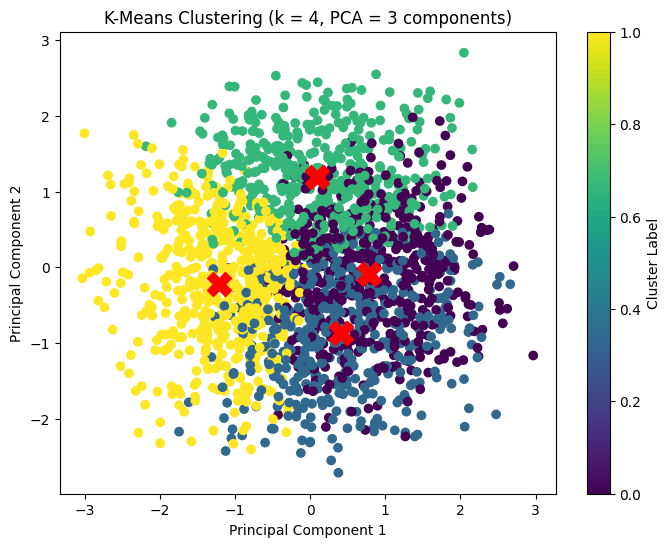

K = 4, PCA = 3:
  Silhouette Score: 0.245
  Calinski-Harabasz Score: 692.961
  Davies-Bouldin Score: 1.137


In [56]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

# Set specific values for k and n_components
k = 4
n_components = 3

# Apply PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)  # Capture the labels here

# Plot the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title(f'K-Means Clustering (k = {k}, PCA = {n_components} components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Compute performance metrics
silhouette = silhouette_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
davies_bouldin = davies_bouldin_score(reduced_data, labels)

print(f"K = {k}, PCA = {n_components}:")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")


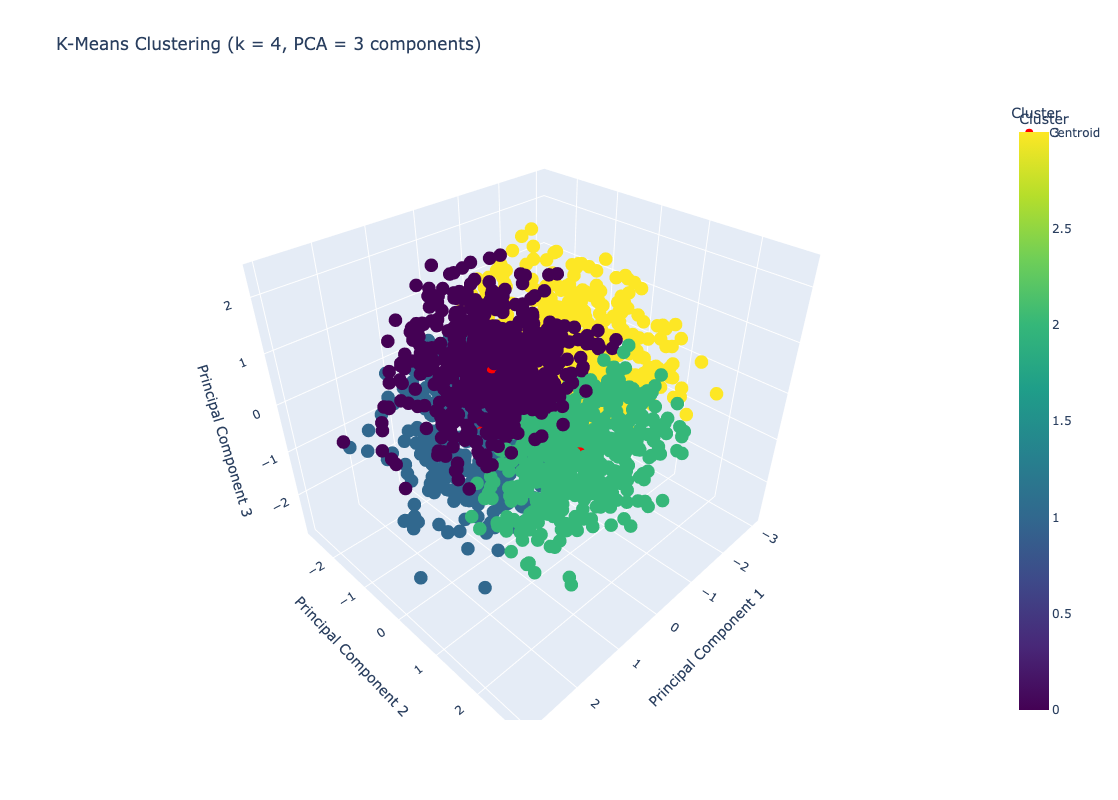

K = 4, PCA = 3:
  Silhouette Score: 0.245
  Calinski-Harabasz Score: 692.961
  Davies-Bouldin Score: 1.137


In [65]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# Assume cleaned_data_ForKmeans_and_Gmm is already defined
# Set specific values for k and n_components
k = 4
n_components = 3

# Apply PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)  # Capture the labels here
centroids = kmeans.cluster_centers_

# Create a DataFrame for Plotly
df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df['Cluster'] = labels

# Create 3D scatter plot
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                    color='Cluster',
                    title=f'K-Means Clustering (k = {k}, PCA = {n_components} components)',
                    color_continuous_scale=px.colors.sequential.Viridis)

# Add centroids to the plot as a separate trace
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])
centroids_df['Cluster'] = ['Centroid'] * len(centroids)

# Use a scatter plot for centroids with custom marker size
fig.add_trace(px.scatter_3d(centroids_df, x='PC1', y='PC2', z='PC3', 
                             color='Cluster', 
                             color_discrete_sequence=['red'],
                             title='Centroids').data[0])

# Update layout for better visibility and increase size
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 3'),
    legend_title_text='Cluster',
    width=1000,  # Set the width of the graph
    height=800   # Set the height of the graph
)

# Show the plot
fig.show()

# Compute performance metrics
silhouette = silhouette_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
davies_bouldin = davies_bouldin_score(reduced_data, labels)

print(f"K = {k}, PCA = {n_components}:")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")


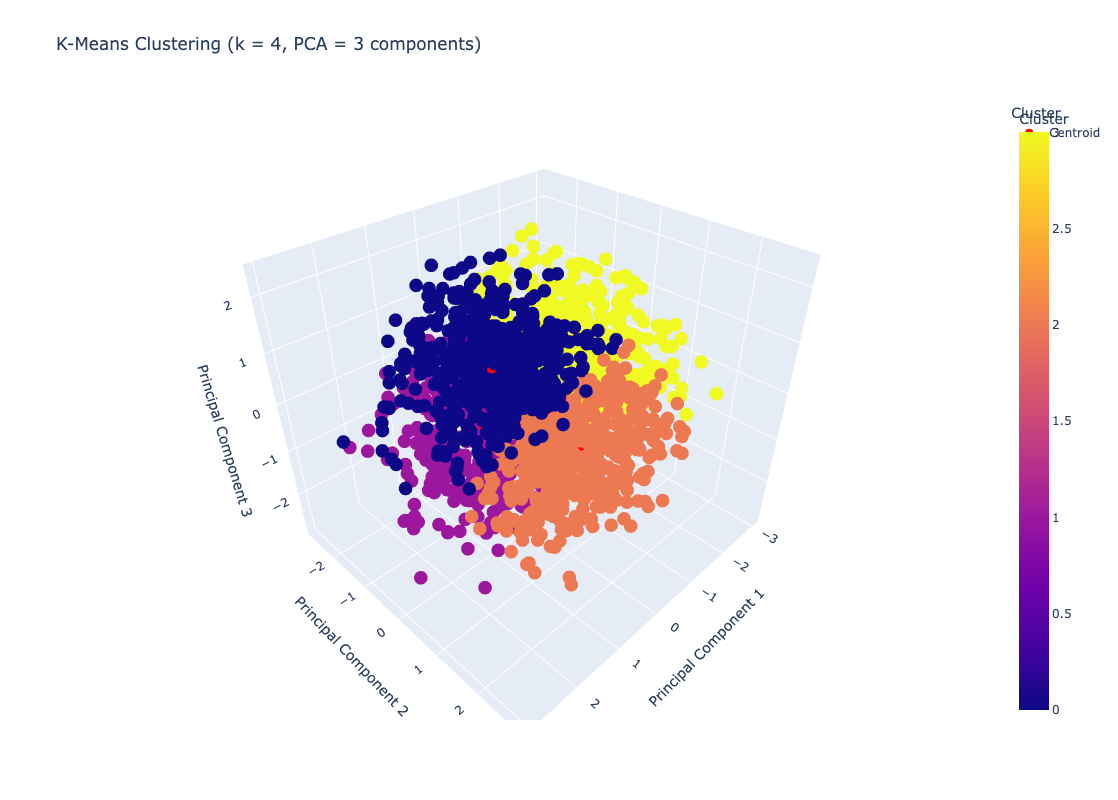

K = 4, PCA = 3:
  Silhouette Score: 0.245
  Calinski-Harabasz Score: 692.961
  Davies-Bouldin Score: 1.137


In [66]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# Assume cleaned_data_ForKmeans_and_Gmm is already defined and is a DataFrame
# Set specific values for k and n_components
k = 4
n_components = 3

# Apply PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(reduced_data)  # Capture the labels here
centroids = kmeans.cluster_centers_

# Create a DataFrame for Plotly with PCA components and clusters
df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df['Cluster'] = labels

# Add the original columns from cleaned_data_ForKmeans_and_Gmm for hover data
# This will display the full row data when hovering over a point
for col in cleaned_data_ForKmeans_and_Gmm.columns:
    df[col] = cleaned_data_ForKmeans_and_Gmm[col]

# Create 3D scatter plot with hover data for each original column
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                    color='Cluster',
                    title=f'K-Means Clustering (k = {k}, PCA = {n_components} components)',
                    hover_data=cleaned_data_ForKmeans_and_Gmm.columns)  # Display full row on hover

# Add centroids to the plot as a separate trace
centroids_df = pd.DataFrame(centroids, columns=['PC1', 'PC2', 'PC3'])
centroids_df['Cluster'] = ['Centroid'] * len(centroids)

# Use a scatter plot for centroids with custom marker size
fig.add_trace(px.scatter_3d(centroids_df, x='PC1', y='PC2', z='PC3', 
                             color='Cluster', 
                             color_discrete_sequence=['red'],
                             title='Centroids').data[0])

# Update layout for better visibility and increase size
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 3'),
    legend_title_text='Cluster',
    width=1000,  # Set the width of the graph
    height=800   # Set the height of the graph
)

# Show the plot
fig.show()

# Compute performance metrics
silhouette = silhouette_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
davies_bouldin = davies_bouldin_score(reduced_data, labels)

print(f"K = {k}, PCA = {n_components}:")
print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")


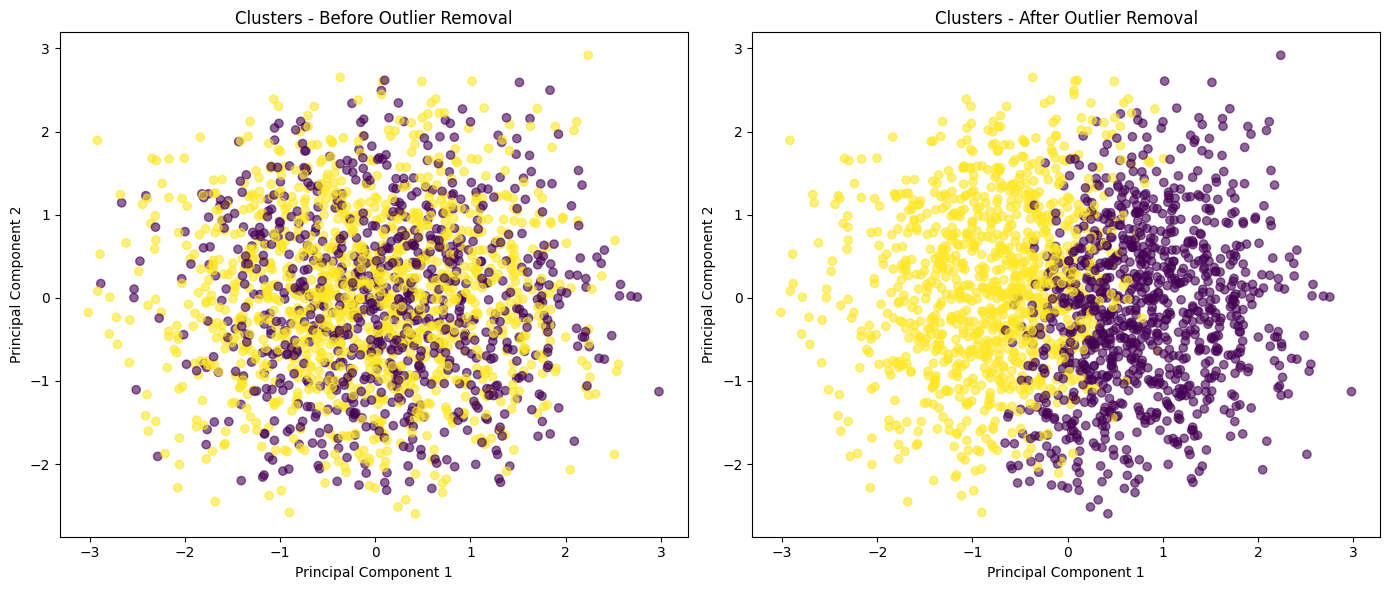

In [58]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set number of clusters
n_clusters = 2

# Fit PCA to the dataset
pca = PCA(n_components=5)
pca.fit(cleaned_data_afterNormalization)

# Cluster both datasets
kmeans_before = KMeans(n_clusters=n_clusters, random_state=0).fit(cleaned_data_afterNormalization)
kmeans_after = KMeans(n_clusters=n_clusters, random_state=0).fit(cleaned_data_ForKmeans_and_Gmm)

# Apply PCA to both datasets
pca_before = pca.transform(cleaned_data_afterNormalization)
pca_after = pca.transform(cleaned_data_ForKmeans_and_Gmm)

# Plot clustering results
plt.figure(figsize=(14, 6))

# Clusters before outlier removal
plt.subplot(1, 2, 1)
plt.scatter(pca_before[:, 0], pca_before[:, 1], c=kmeans_before.labels_, cmap='viridis', alpha=0.6)
plt.title("Clusters - Before Outlier Removal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Clusters after outlier removal
plt.subplot(1, 2, 2)
plt.scatter(pca_after[:, 0], pca_after[:, 1], c=kmeans_after.labels_, cmap='viridis', alpha=0.6)
plt.title("Clusters - After Outlier Removal")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


In [59]:
#determine an optimal value for the eps parameter in the DBSCAN clustering algorithm by generating a K-distance graph

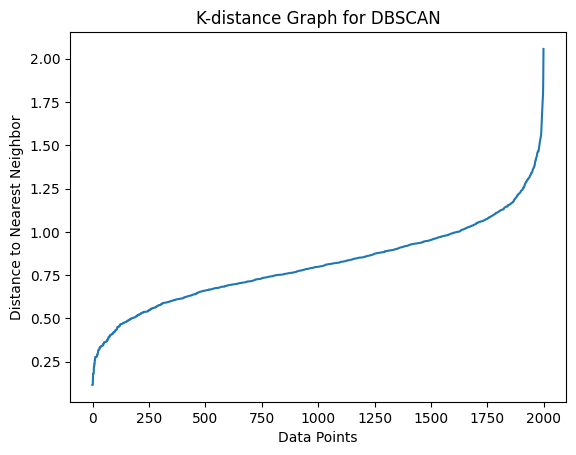

In [61]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Determine eps using Nearest Neighbors =distance to the nearest neighbor starts to increase sharply
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cleaned_data_afterNormalization)
distances, indices = nbrs.kneighbors(cleaned_data_afterNormalization)
distances = np.sort(distances[:, 1], axis=0)

plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('Distance to Nearest Neighbor')
plt.title('K-distance Graph for DBSCAN')
plt.show()

In [62]:
from sklearn.cluster import DBSCAN
import pandas as pd
from tabulate import tabulate

# Define your parameter values
min_samples_values = [7,8, 9, 10, 11]  # Start around 8-10 based on dimensionality
eps_values = [1.25,1.5, 1.75, 2.0]  # Adjust these based on K-distance graph
cleaned_data_dbscan=cleaned_data_afterNormalization.copy()

# Assume cleaned_data is already defined
results = []  # To store results for each combination

# Variable to track the best eps and min_samples with the least -1 count
best_eps = None
best_min_samples = None
min_noise_count = float('inf')  # Start with infinity for comparison

# Loop through all combinations of eps and min_samples
for min_samples in min_samples_values:
    for eps in eps_values:
        # Fit the DBSCAN model
        db_scanclustermodel = DBSCAN(eps=eps, min_samples=min_samples).fit(cleaned_data_afterNormalization)

        # Add the cluster labels to cleaned_data
        cleaned_data_dbscan.loc[:, 'cluster'] = db_scanclustermodel.labels_

        # Count and print the number of clusters, including noise (-1)
        cluster_counts = cleaned_data_dbscan['cluster'].value_counts()
        noise_count = cluster_counts.get(-1, 0)  # Get count of noise points, default to 0

        print(f"DBSCAN with eps={eps} and min_samples={min_samples}")
        print(tabulate(cleaned_data_dbscan.head(), headers='keys', tablefmt='grid'))
        print(f"Noise points (-1) count: {noise_count}")
        
        # Check if this is the least noise count observed so far
        if noise_count < min_noise_count:
            min_noise_count = noise_count
            best_eps = eps
            best_min_samples = min_samples
        
        # Append the result for further analysis if needed
        results.append((eps, min_samples, noise_count))

# Print the best parameters with the least -1 cluster count
print(f"\nBest eps: {best_eps}, Best min_samples: {best_min_samples} with noise count: {min_noise_count}")

# Optionally, save the last cleaned data to CSV
# cleaned_data.to_csv('cleaned_Customers_dataset4.csv', index=False)


DBSCAN with eps=1.25 and min_samples=7
+----+-----------+-----------+---------------------+--------------------------+--------------+-------------------+---------------+-----------+
|    |    Gender |       Age |   Annual Income ($) |   Spending Score (1-100) |   Profession |   Work Experience |   Family Size |   cluster |
+====+===========+===========+=====================+==========================+==============+===================+===============+===========+
|  0 |  1.20706  | -1.05409  |           -2.0935   |                -0.428339 |    0.870495  |         -0.791207 |      0.117497 |         0 |
+----+-----------+-----------+---------------------+--------------------------+--------------+-------------------+---------------+-----------+
|  1 |  1.20706  | -0.983723 |           -1.65613  |                 1.07555  |   -0.30638   |         -0.281162 |     -0.390051 |         0 |
+----+-----------+-----------+---------------------+--------------------------+--------------+---------


Silhouette Score: 0.17442435336154655
Davies-Bouldin Index: 1.7015086151224186


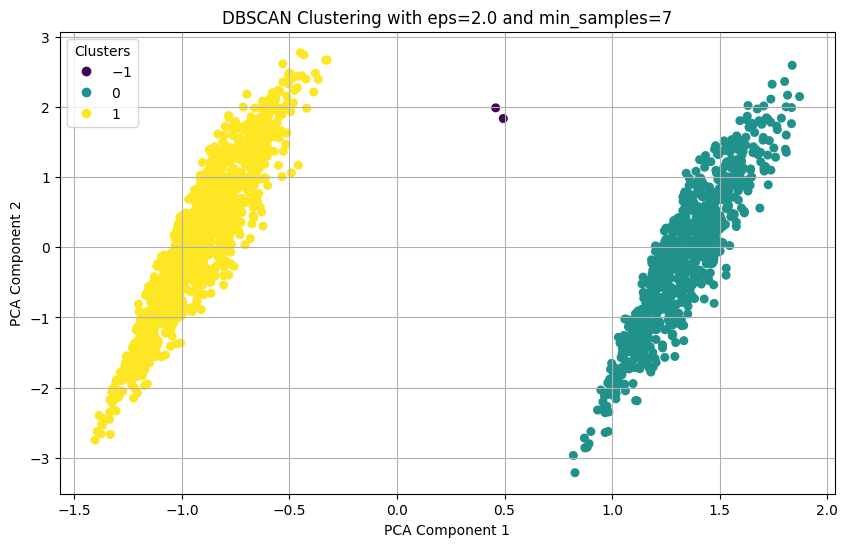

In [64]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the best parameters obtained from previous runs
best_eps = 2.0
best_min_samples = 7

# Fit the DBSCAN model with the best parameters
db_scanclustermodel = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(cleaned_data_dbscan)

# Add the cluster labels to cleaned_data
cleaned_data_dbscan.loc[:, 'cluster'] = db_scanclustermodel.labels_
# Calculate performance metrics
if len(set(db_scanclustermodel.labels_)) > 1:  # Ensure there is more than one cluster
    silhouette_avg = silhouette_score(cleaned_data_dbscan, db_scanclustermodel.labels_)
    db_index = davies_bouldin_score(cleaned_data_dbscan, db_scanclustermodel.labels_)
else:
    silhouette_avg = -1  # If there's only one cluster or all are noise
    db_index = float('inf')  # Arbitrarily high since there's no valid clustering

# Print the metrics
print(f"\nSilhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {db_index}")

# PCA for 2D visualization
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(cleaned_data_dbscan)

# Create a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cleaned_data_dbscan['cluster'], cmap='viridis', marker='o', s=30)
plt.title(f"DBSCAN Clustering with eps={best_eps} and min_samples={best_min_samples}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Create a legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")
# Show the plot
plt.grid()
plt.show()


In [24]:
#GMM optimal number of components

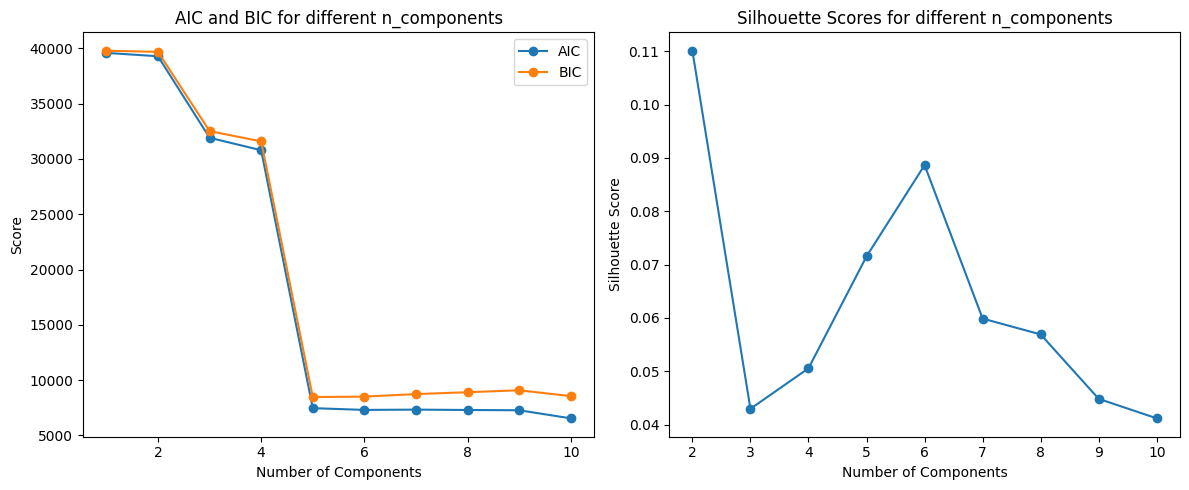

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Range of components to try
n_components_range = range(1, 11)
aic_values = []
bic_values = []
silhouette_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(cleaned_data_ForKmeans_and_Gmm)
    
    # Append AIC and BIC values
    aic_values.append(gmm.aic(cleaned_data_ForKmeans_and_Gmm))
    bic_values.append(gmm.bic(cleaned_data_ForKmeans_and_Gmm))
    
    # If there are more than one cluster, compute silhouette score
    if n_components > 1:
        cluster_labels = gmm.predict(cleaned_data_ForKmeans_and_Gmm)
        silhouette_avg = silhouette_score(cleaned_data_ForKmeans_and_Gmm, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)  # Not defined for a single cluster

# Plotting AIC and BIC-- lowest points on the AIC and BIC curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, aic_values, marker='o', label='AIC')
plt.plot(n_components_range, bic_values, marker='o', label='BIC')
plt.title('AIC and BIC for different n_components')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

# Plotting silhouette scores--highest silhouette score indicates the best-defined clusters
plt.subplot(1, 2, 2)
plt.plot(n_components_range[1:], silhouette_scores[1:], marker='o')
plt.title('Silhouette Scores for different n_components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


Cluster counts for GMM with 2 components:
0    1000
1     995
Name: count, dtype: int64

Cluster counts for GMM with 7 components:
0    362
1    446
2    363
3    390
4    434
Name: count, dtype: int64


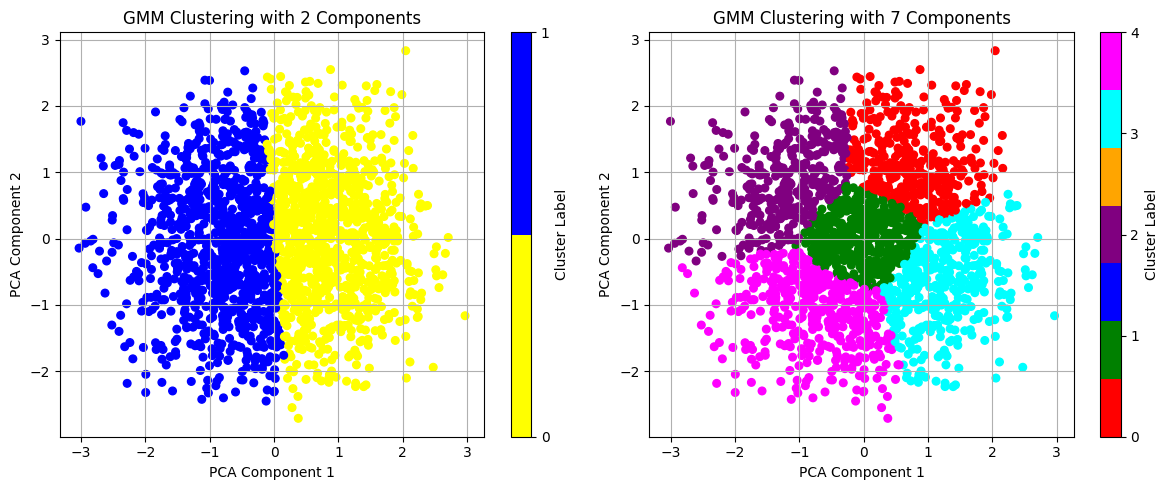

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap  # Import ListedColormap from matplotlib.colors

# Assuming cleaned_data is already defined and contains the normalized data
# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cleaned_data_ForKmeans_and_Gmm)

# Fit GMM with 2 components
gmm_2 = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_2.fit(reduced_data)
labels_2 = gmm_2.predict(reduced_data)

# Fit GMM with 7 components
gmm_7 = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_7.fit(reduced_data)
labels_7 = gmm_7.predict(reduced_data)

# Count points in each cluster for 2 components
cluster_counts_2 = pd.Series(labels_2).value_counts().sort_index()
print("Cluster counts for GMM with 2 components:")
print(cluster_counts_2)

# Count points in each cluster for 7 components
cluster_counts_7 = pd.Series(labels_7).value_counts().sort_index()
print("\nCluster counts for GMM with 7 components:")
print(cluster_counts_7)

# Optional: Visualize clusters with scatter plots
plt.figure(figsize=(12, 5))

# Define custom colors for clusters (you can choose your own colors)
colors_2 = ['yellow', 'blue']  # Colors for 2 clusters
colors_7 = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta']  # Colors for 7 clusters

# Visualize results for 2 components
plt.subplot(1, 2, 1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_2, cmap=ListedColormap(colors_2), marker='o', s=30)
plt.title('GMM Clustering with 2 Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(ticks=range(len(colors_2)), label='Cluster Label')
plt.grid()

# Visualize results for 7 components
plt.subplot(1, 2, 2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_7, cmap=ListedColormap(colors_7), marker='o', s=30)
plt.title('GMM Clustering with 7 Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(ticks=range(len(colors_7)), label='Cluster Label')
plt.grid()

plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Function to calculate performance metrics
def calculate_performance_metrics(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette_avg, calinski_harabasz, davies_bouldin

# Calculate performance metrics for GMM with 2 components
metrics_2 = calculate_performance_metrics(reduced_data, labels_2)
print(f"Performance Metrics for GMM with 2 Components:")
print(f"Silhouette Score: {metrics_2[0]}")
print(f"Calinski-Harabasz Index: {metrics_2[1]}")
print(f"Davies-Bouldin Index: {metrics_2[2]}")

# Calculate performance metrics for GMM with 7 components
metrics_7 = calculate_performance_metrics(reduced_data, labels_7)
print(f"\nPerformance Metrics for GMM with 7 Components:")
print(f"Silhouette Score: {metrics_7[0]}")
print(f"Calinski-Harabasz Index: {metrics_7[1]}")
print(f"Davies-Bouldin Index: {metrics_7[2]}")

Performance Metrics for GMM with 2 Components:
Silhouette Score: 0.32279262526654956
Calinski-Harabasz Index: 1059.5400303383065
Davies-Bouldin Index: 1.2216524305798588

Performance Metrics for GMM with 7 Components:
Silhouette Score: 0.3189748097016432
Calinski-Harabasz Index: 1270.061788307555
Davies-Bouldin Index: 0.9074958739003511
